## 1. Preprocess a subset of an RGI region
This example shows how to run the first steps of the OGGM preprocessing chain for a subset of the Alps - the Rofental catchment in the Austrian Alps (see [docs.oggm.org](http://docs.oggm.org/en/latest/run_examples/run_rgi_region.html)).

In [1]:
# Python imports
import os

# Libs
import geopandas as gpd
import shapely.geometry as shpg

# Locals
import oggm.cfg as cfg
from oggm import utils, workflow

In [2]:
# Initialize OGGM and set up the default run parameters
cfg.initialize()
rgi_version = '61'
rgi_region = '11'  # Alps

# Local working directory (where OGGM will write its output)
WORKING_DIR = utils.gettempdir('OGGM_Rofental')
utils.mkdir(WORKING_DIR, reset=True)
cfg.PATHS['working_dir'] = WORKING_DIR

2019-02-25 11:19:57: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg


In [3]:
WORKING_DIR

'/var/folders/dc/r0qdkr9n45n4c2f2cc7v7pfr0000gn/T/OGGM/OGGM_Rofental'

In [4]:
# We use intersects
path = utils.get_rgi_intersects_region_file(rgi_region, version=rgi_version)
cfg.set_intersects_db(path)

In [5]:
# RGI file
path = utils.get_rgi_region_file(rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# Get the Rofental Basin file
path = utils.get_demo_file('rofental_hydrosheds.shp')
basin = gpd.read_file(path)

In [6]:
# Take all glaciers in the Rofental Basin
in_bas = [basin.geometry.contains(shpg.Point(x, y))[0] for
          (x, y) in zip(rgidf.CenLon, rgidf.CenLat)]
rgidf = rgidf.loc[in_bas]
# Store them for later
rgidf.to_file(os.path.join(WORKING_DIR, 'rgi_rofental.shp'))

In [11]:
# Sort for more efficient parallel computing
rgidf = rgidf.sort_values('Area', ascending=False)
cfg.PARAMS['use_multiprocessing'] = True

print('Starting OGGM run')
print('Number of glaciers: {}'.format(len(rgidf)))

# Go - initialize glacier directories
gdirs_list = workflow.init_glacier_regions(rgidf)

Starting OGGM run
Number of glaciers: 54


In [12]:
# select single glacier
gdirs = [gdirs_list[1]]
gdirs

[<oggm.GlacierDirectory>
   RGI id: RGI60-11.00897
   Region: 11: Central Europe
   Subregion: 11-01: Alps                            
   Name: Hintereisferner
   Glacier type: Glacier
   Terminus type: Land-terminating
   Area: 8.036 km2
   Lon, Lat: (10.7584, 46.8003)
   Grid (nx, ny): (159, 114)
   Grid (dx, dy): (50.0, -50.0)]

In [13]:
from oggm.core import vascaling, climate
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

# Tasks shortcuts - see the next examples for more details
workflow.gis_prepro_tasks(gdirs)

2019-02-25 11:21:57: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-02-25 11:21:57: oggm.workflow: Multiprocessing: using all available processors (N=4)
2019-02-25 11:21:57: oggm.core.gis: (RGI60-11.00897) glacier_masks
2019-02-25 11:21:57: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-02-25 11:21:58: oggm.core.centerlines: (RGI60-11.00897) compute_centerlines
2019-02-25 11:21:58: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-02-25 11:21:58: oggm.core.centerlines: (RGI60-11.00897) initialize_flowlines
2019-02-25 11:21:58: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-02-25 11:21:58: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_line
2019-02-25 11:21:58: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-02-25 11:21:58: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_bedshape
2019-02-25 11:21:59: oggm.workflow: Execute entit

In [14]:
# execute climate tasks
workflow.execute_entity_task(climate.process_histalp_data, gdirs);
workflow.execute_entity_task(vascaling.local_t_star, gdirs);

2019-02-25 11:22:08: oggm.workflow: Execute entity task process_histalp_data on 1 glaciers
2019-02-25 11:22:11: oggm.workflow: Execute entity task local_t_star on 1 glaciers


In [ ]:
mbmo

In [ ]:
# Compile output
utils.compile_glacier_statistics(gdirs)
utils.write_centerlines_to_shape(gdirs)

In [ ]:
# Imports
from os import path
import geopandas as gpd
import matplotlib.pyplot as plt
from oggm.utils import get_demo_file, gettempdir

# Local working directory (where OGGM wrote its output)
WORKING_DIR = gettempdir('OGGM_Rofental')

# Plot: the basin, the outlines and the centerlines
basin = gpd.read_file(get_demo_file('rofental_hydrosheds.shp'))
rgi = gpd.read_file(path.join(WORKING_DIR, 'rgi_rofental.shp'))
centerlines = gpd.read_file(path.join(WORKING_DIR, 'glacier_centerlines.shp'))

f, ax = plt.subplots()
basin.plot(ax=ax, color='k', alpha=0.2)
rgi.plot(ax=ax, color='C0')
centerlines.plot(ax=ax, color='C3')
plt.title('Rofental glaciers and centerlines')
plt.tight_layout()
plt.show()


## 2. Complete run for a list of glaciers
This example shows how to run the OGGM model for a list of selected glaciers.

Note that the default in OGGM is to use a previously calibrated list of $t^*$ for the run, which means that we don't have to calibrate the mass balance model ourselves (thankfully, otherwise you'd have to add all the calibration glaciers to your list too).

Note that in order to be correct, the automated calibration can only be used if the model parameters don't change between the calibration and the run. After testing, it appears that changing the `border` parameter won't affect the results much (as expected). So it's ok to change this parameters. Some other parameters (e.g. topo smoothing, dx, precipitation factor, alternative climate data, ...) will probaly need a re-calibration step (see [3. Run the mass balance calibration](http://docs.oggm.org/en/latest/run_examples/run_mb_calibration.html)).


In [ ]:
import importlib
importlib.reload(vascaling)
importlib.reload(workflow)

In [ ]:
# Random climate representative for the tstar climate, without bias
# In an ideal world this would imply that the glaciers remain stable,
# but it doesn't have to be so
nyears=200
workflow.execute_entity_task(vascaling.run_random_vas_climate, gdirs,
                             nyears=nyears, bias=0, seed=12);

In [ ]:
import numpy as np
import pandas as pd
# create empty container
volume_m3 = pd.DataFrame(index=np.arange(0,nyears))
# iterate over all gdirs
for gdir in gdirs:
    path = gdir.get_filepath('model_diagnostics', filesuffix='vas')
    df = pd.read_csv(path, index_col=0)
    vol = df.volume_m3
    rgi_id = gdir.rgi_id
    volume_m3[rgi_id] = vol

In [ ]:
volume_m3.sum(axis=1).plot()

## Test some stuff

In [18]:
# Python imports
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry as shpg

# Locals
import oggm.cfg as cfg
from oggm import utils, workflow
from oggm.core import vascaling, climate

In [19]:
# Initialize OGGM and set up the default run parameters
cfg.initialize()
rgi_version = '61'
rgi_region = '11'  # Alps

# Local working directory (where OGGM will write its output)

wdir = '/Users/oberrauch/master/working_sirectories/commitment_run_vas/'
utils.mkdir(wdir)
cfg.PATHS['working_dir'] = wdir

# We use intersects
path = utils.get_rgi_intersects_region_file(rgi_region, version=rgi_version)
cfg.set_intersects_db(path)

# RGI file
path = utils.get_rgi_region_file(rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# Get the Rofental Basin file
path = utils.get_demo_file('rofental_hydrosheds.shp')
basin = gpd.read_file(path)

# Take all glaciers in the Rofental Basin
in_bas = [basin.geometry.contains(shpg.Point(x, y))[0] for
          (x, y) in zip(rgidf.CenLon, rgidf.CenLat)]
rgidf = rgidf.loc[in_bas]
# Store them for later
rgidf.to_file(os.path.join(wdir, 'rgi_rofental.shp'))

# Sort for more efficient parallel computing
rgidf = rgidf.sort_values('Area', ascending=False)
cfg.PARAMS['use_multiprocessing'] = True

# Go - initialize glacier directories
gdirs = workflow.init_glacier_regions(rgidf)

2019-02-24 14:09:05: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg


In [33]:
# select Hintereisferener
gdir = gdirs[0]
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75
vascaling.run_random_vas_climate(gdir, y0=2000)

ValueError: year 2015.0 out of the valid time bounds: [1802, 2014]

In [30]:
path = gdir.get_filepath('model_diagnostics', filesuffix='vas')
df = pd.read_csv(path, index_col=0)
df.head()

,year0,length_m,length_m_0,dL,area_m2,area_m2_0,dA,volume_m3,volume_m3_0,dV,...,tau_a,ca,gamma,cl,ql,min_hgt,min_hgt_0,max_hgt,rho,spec_mb
0,0.0,5091.373049,5091.373049,0.000000,8.559000e+06,8559000.0,0.000000,6.503019e+08,6.503019e+08,0.000000e+00,...,1.000000,0.191,1.375,4.5507,2.2,2809.000000,2809.0,3560.0,900.0,36.261903
1,0.0,5091.396209,5091.373049,0.023160,8.559189e+06,8559000.0,188.679123,6.506468e+08,6.503019e+08,3.448507e+05,...,17.493679,0.191,1.375,4.5507,2.2,2808.996584,2809.0,3560.0,900.0,36.261903
2,0.0,5091.985267,5091.373049,0.589058,8.563989e+06,8559000.0,4800.135265,6.591150e+08,6.503019e+08,8.468247e+06,...,17.502797,0.191,1.375,4.5507,2.2,2808.909695,2809.0,3560.0,900.0,890.437501
3,0.0,5092.796912,5091.373049,0.811645,8.570427e+06,8559000.0,6438.442079,6.627788e+08,6.503019e+08,3.663820e+06,...,17.726496,0.191,1.375,4.5507,2.2,2808.789974,2809.0,3560.0,900.0,385.035340
4,0.0,5093.665947,5091.373049,0.869036,8.577095e+06,8559000.0,6668.204046,6.639480e+08,6.503019e+08,1.169135e+06,...,17.819351,0.191,1.375,4.5507,2.2,2808.661787,2809.0,3560.0,900.0,122.773469


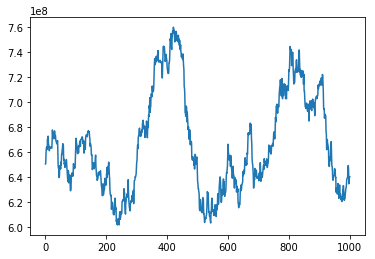

In [32]:
df.volume_m3.plot()

### Access `model_diagnostice` from already run gdirs

In [16]:
# Python imports
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry as shpg

# Locals
import oggm.cfg as cfg
from oggm import utils, workflow
from oggm.core import vascaling, climate

In [67]:
# Initialize OGGM and set up the default run parameters
cfg.initialize()
rgi_version = '61'
rgi_region = '11'  # Alps

# Local working directory (where OGGM will write its output)

wdir = '/Users/oberrauch/master/working_sirectories/commitment_run_vas/'
utils.mkdir(wdir)
cfg.PATHS['working_dir'] = wdir

# We use intersects
path = utils.get_rgi_intersects_region_file(rgi_region, version=rgi_version)
cfg.set_intersects_db(path)

# RGI file
path = utils.get_rgi_region_file(rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# Get the Rofental Basin file
path = utils.get_demo_file('rofental_hydrosheds.shp')
basin = gpd.read_file(path)

# Take all glaciers in the Rofental Basin
in_bas = [basin.geometry.contains(shpg.Point(x, y))[0] for
          (x, y) in zip(rgidf.CenLon, rgidf.CenLat)]
rgidf = rgidf.loc[in_bas]
# Store them for later
rgidf.to_file(os.path.join(wdir, 'rgi_rofental.shp'))

# Sort for more efficient parallel computing
rgidf = rgidf.sort_values('Area', ascending=False)
cfg.PARAMS['use_multiprocessing'] = True

# Go - initialize glacier directories
gdirs = workflow.init_glacier_regions(rgidf)

2019-02-24 14:20:41: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg


In [68]:
nyears = 300
# create empty container
volume_m3 = pd.DataFrame(index=np.arange(0,nyears))
# iterate over all gdirs
for gdir in gdirs:
    path = gdir.get_filepath('model_diagnostics', filesuffix='vas')
    df = pd.read_csv(path, index_col=0)
    vol = df.volume_m3
    rgi_id = gdir.rgi_id
    volume_m3[rgi_id] = vol

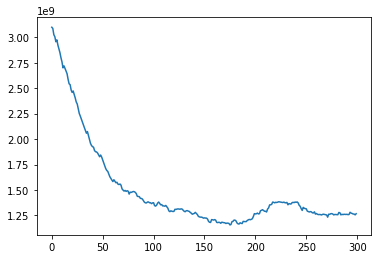

In [89]:
volume_m3.sum(axis=1).plot()

In [101]:
# Imports
import os
import xarray as xr
import matplotlib.pyplot as plt
from oggm.utils import get_demo_file, gettempdir

# Local working directory (where OGGM wrote its output)
wdir = '/Users/oberrauch/master/working_sirectories/commitment_run_oggm/'
# Read the files using xarray
ds = xr.open_dataset(os.path.join(wdir, 'run_output_commitment.nc'))

Text(0,0.5,'Volume [m$^3$]')

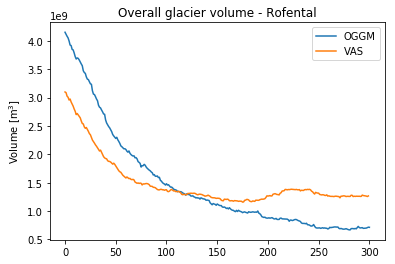

In [106]:
# Volume
(ds.volume.sum(dim='rgi_id')).plot(label='OGGM')
volume_m3.sum(axis=1).plot(label='VAS')
plt.legend()
plt.title('Overall glacier volume - Rofental')
plt.xlabel('')
plt.ylabel('Volume [m$^3$]')

In [70]:
# Local working directory (where OGGM will write its output)
wdir = '/Users/oberrauch/master/working_sirectories/commitment_run_oggm/'
utils.mkdir(wdir, reset=False)
cfg.PATHS['working_dir'] = wdir
gdirs = workflow.init_glacier_regions()

2019-02-24 14:30:45: oggm.workflow: init_glacier_regions by parsing available folders (can be slow).


In [74]:
from oggm.core import flowline
flowline.init_present_time_glacier(gdirs[1])

2019-02-24 14:31:27: oggm.core.flowline: (RGI60-11.00675) init_present_time_glacier


In [80]:
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75
flowline.run_random_climate(gdirs[1], nyears=300, y0=1999, seed=2,
                            output_filesuffix='_commitment')

2019-02-24 14:34:09: oggm.core.flowline: (RGI60-11.00675) run_random_climate_commitment
2019-02-24 14:34:09: oggm.core.flowline: (RGI60-11.00675) trying default time stepping scheme.
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
2019-02-24 14:34:12: oggm.core.flowline: (RGI60-11.00675) default time stepping was successful!


In [93]:
path = gdirs[1].get_filepath('model_diagnostics', filesuffix='_commitment')
path

'/Users/oberrauch/master/working_sirectories/commitment_run_oggm/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00675/model_diagnostics_commitment.nc'

In [ ]:
nyears = 300
# create empty container
volume_m3 = pd.DataFrame(index=np.arange(0,nyears))
# iterate over all gdirs
for gdir in gdirs:

    df = pd.read_csv(path, index_col=0)
    vol = df.volume_m3
    rgi_id = gdir.rgi_id
    volume_m3[rgi_id] = vol

In [ ]:
path

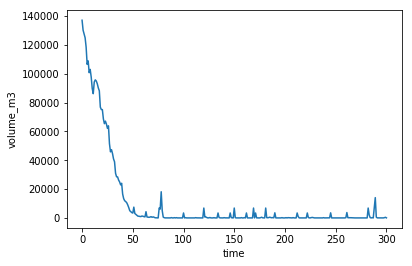

In [87]:
import xarray as xa
ds = xa.open_dataset(path)
ds.volume_m3.plot()

### Quick test of RandomClimate

In [34]:
# quick-test of the RandomVASMassBalanceModel
import importlib
importlib.reload(vascaling)

<module 'oggm.core.vascaling' from '/Users/oberrauch/oggm-fork/oggm/core/vascaling.py'>

In [35]:
import numpy as np

In [36]:
# select Hintereisferner gdir
gdir = gdirs[int(np.where([gdir.name == 'Hintereisferner' for gdir in gdirs])[0])]
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-11.00897
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Name: Hintereisferner
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 8.036 km2
  Lon, Lat: (10.7584, 46.8003)
  Grid (nx, ny): (159, 114)
  Grid (dx, dy): (50.0, -50.0)

In [61]:
rand_mbmod = vascaling.RandomVASMassBalance(gdir=gdir, seed=12, y0=1999)

In [62]:
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)
year = 2043
r_yr = rand_mbmod.get_state_yr(year)
mb = rand_mbmod.get_specific_mb(min_hgt, max_hgt, year)
print('Year {} correpsonds to mb year {}, resulting in {} mm w.e. yr-1'.format(year, r_yr, mb))

Year 2043 correpsonds to mb year 1995, resulting in -410.4912065804235 mm w.e. yr-1


In [63]:
years = np.arange(2018, 2200)
mb = np.empty(years.size)
r_yrs = np.empty(years.size)
for i, year in enumerate(years):
    mb[i] = rand_mbmod.get_specific_mb(min_hgt, max_hgt, year)
    r_yrs[i] = rand_mbmod.get_state_yr(year)

import pandas as pd
df = pd.DataFrame({'mb':mb, 'r_yr':r_yrs}, index=years)

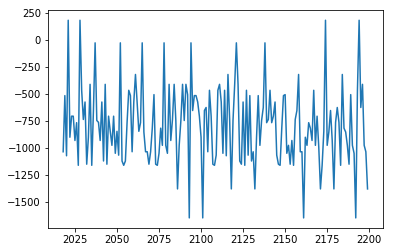

In [64]:
df.mb.plot()

In [65]:
local_tstar = gdir.read_json('vascaling_mustar')
t_star = local_tstar['t_star']

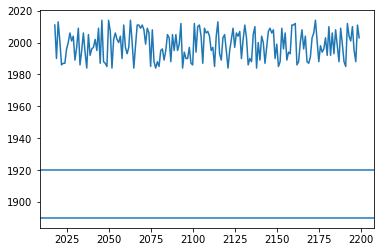

In [66]:
import matplotlib.pyplot as plt
df.r_yr.plot()
plt.axhline(t_star-15)
plt.axhline(t_star+15)

In [119]:
ls /Users/oberrauch/master/working_sirectories/commitment_run_vas/per_glacier/RGI60-11/RGI60-11.00/

RGI60-11.00674/ RGI60-11.00737/ RGI60-11.00814/ RGI60-11.00888/ RGI60-11.00944/
RGI60-11.00675/ RGI60-11.00739/ RGI60-11.00822/ RGI60-11.00895/ RGI60-11.00945/
RGI60-11.00690/ RGI60-11.00745/ RGI60-11.00831/ RGI60-11.00897/ RGI60-11.00947/
RGI60-11.00702/ RGI60-11.00747/ RGI60-11.00834/ RGI60-11.00898/ RGI60-11.00957/
RGI60-11.00718/ RGI60-11.00753/ RGI60-11.00839/ RGI60-11.00902/ RGI60-11.00958/
RGI60-11.00719/ RGI60-11.00757/ RGI60-11.00844/ RGI60-11.00904/ RGI60-11.00959/
RGI60-11.00720/ RGI60-11.00762/ RGI60-11.00860/ RGI60-11.00919/ RGI60-11.00962/
RGI60-11.00724/ RGI60-11.00779/ RGI60-11.00862/ RGI60-11.00927/ RGI60-11.00980/
RGI60-11.00726/ RGI60-11.00782/ RGI60-11.00873/ RGI60-11.00935/ RGI60-11.00984/
RGI60-11.00729/ RGI60-11.00787/ RGI60-11.00885/ RGI60-11.00937/
RGI60-11.00731/ RGI60-11.00802/ RGI60-11.00886/ RGI60-11.00943/


### Store to xarray

In [19]:
path = '/Users/oberrauch/master/working_sirectories/commitment_run_oggm/'+\
    'per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00731/model_run_commitment.nc'
import xarray as xr
xr.open_dataarray(path)

<xarray.DataArray 'flows_to_id' (flowlines: 1)>
array([-1])
Coordinates:
  * flowlines  (flowlines) int64 0

In [121]:
path = '/Users/oberrauch/master/working_sirectories/commitment_run_vas/'+\
    'per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00739/model_diagnosticsvas.nc'
df = pd.read_csv(path, index_col=0)
df.head()

,year0,length_m,length_m_0,dL,area_m2,area_m2_0,dA,volume_m3,volume_m3_0,dV,...,tau_a,ca,gamma,cl,ql,min_hgt,min_hgt_0,max_hgt,rho,spec_mb
0,0.0,758.694671,758.694671,0.000000,407000.000000,407000.0,0.000000,9.867921e+06,9.867921e+06,0.000000,...,1.000000,0.191,1.375,4.5507,2.2,2648.000000,2648.0,3349.0,900.0,-174.906496
1,0.0,758.562132,758.694671,-0.132539,406839.285439,407000.0,-160.714561,9.788825e+06,9.867921e+06,-79096.604372,...,14.778988,0.191,1.375,4.5507,2.2,2648.122460,2648.0,3349.0,900.0,-174.906496
2,0.0,757.753797,758.694671,-0.808335,405867.823952,407000.0,-971.461487,9.390811e+06,9.867921e+06,-398013.433431,...,14.665650,0.191,1.375,4.5507,2.2,2648.869326,2648.0,3349.0,900.0,-880.475664
3,0.0,756.613577,758.694671,-1.140219,404519.860577,407000.0,-1347.963375,9.202876e+06,9.867921e+06,-187935.725235,...,14.099378,0.191,1.375,4.5507,2.2,2649.922838,2648.0,3349.0,900.0,-416.741961
4,0.0,754.996355,758.694671,-1.617223,402633.694285,407000.0,-1886.166292,8.926560e+06,9.867921e+06,-276315.745780,...,13.858888,0.191,1.375,4.5507,2.2,2651.417079,2648.0,3349.0,900.0,-614.763811


In [126]:
from time import gmtime, strftime
import xarray as xr

In [128]:
diag_ds = xr.Dataset()

# Global attributes
diag_ds.attrs['description'] = 'OGGM model output'
# diag_ds.attrs['oggm_version'] = __version__
diag_ds.attrs['calendar'] = '365-day no leap'
diag_ds.attrs['creation_date'] = strftime("%Y-%m-%d %H:%M:%S",
                                          gmtime())


diag_ds

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes:
    description:    OGGM model output
    calendar:       365-day no leap
    creation_date:  2019-02-25 10:03:17

In [129]:
# Coordinates
diag_ds.coords['time'] = ('time', monthly_time)
diag_ds.coords['hydro_year'] = ('time', yrs)
diag_ds.coords['hydro_month'] = ('time', months)
diag_ds.coords['calendar_year'] = ('time', cyrs)
diag_ds.coords['calendar_month'] = ('time', cmonths)

NameError: name 'monthly_time' is not defined

In [130]:
utils.monthly_timeseries(20, 10)

array([], dtype=float64)

In [ ]:
# time
        yearly_time = np.arange(np.floor(self.yr), np.floor(y1)+1)

        if store_monthly_step:
            monthly_time = utils.monthly_timeseries(self.yr, y1)
        else:
            monthly_time = np.arange(np.floor(self.yr), np.floor(y1)+1)
        yrs, months = utils.floatyear_to_date(monthly_time)
        cyrs, cmonths = utils.hydrodate_to_calendardate(yrs, months)